In [12]:
import os
import xarray as xr
import numpy as np
import cftime
import glob
import matplotlib.pyplot as plt

from osprey.utils.folders import folders
from osprey.utils.time import get_startleg, get_year
from osprey.means.means import timemean
from osprey.actions.reader import elements
from osprey.utils import run_cdo

In [15]:
expname = "FE00"
var = "tn"
ndim ="3D"
endleg = 11
yearspan = 5
yearleap = 10
startleg = get_startleg(endleg, yearspan)
startyear = get_year(startleg)
endyear = get_year(endleg)
window = endyear - startyear + 1
dirs = folders(expname)

In [16]:
run_cdo.merge_rebuilt(expname, startleg, endleg)
run_cdo.detrend(expname, var, endleg)
run_cdo.get_EOF(expname, var, endleg, window)

Command: 'cdo -selname,tn /ec/res4/scratch/itas/martini/FE00/007/FE00*_restart.nc /ec/res4/scratch/itas/martini/FE00/007/aux.nc' 

/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'

Command: 'cdo -settaxis,1996-01-01,00:00:00,1year /ec/res4/scratch/itas/martini/FE00/007/aux.nc /ec/res4/scratch/itas/martini/FE00/007/tn_7.nc' 

/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'

File /ec/res4/scratch

In [43]:
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_pattern.nc")
pattern = xr.open_mfdataset(filename, use_cftime=True)
field = pattern.isel(time_counter=0)*0
for i in range(window-1):
    filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_series_0000{i}.nc")
    timeseries = xr.open_mfdataset(filename, use_cftime=True)
    theta = timeseries[var].isel(time_counter=-1,lat=0,lon=0,zaxis_Reduced=0)
    basis = pattern.isel(time_counter=i)
    field = field + theta*basis
field = field.drop_vars({'time_counter','lon','lat','zaxis_Reduced'})

In [44]:
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}.nc")
xdata = xr.open_mfdataset(filename, use_cftime=True)
xdata = xdata.rename({'time_counter': 'time'})
ave = timemean(xdata, var)
total = field + ave
total

<xarray.Dataset> Size: 7MB
Dimensions:  (nav_lev: 31, y: 148, x: 180)
Coordinates:
  * nav_lev  (nav_lev) float32 124B 5.0 15.0 25.0 ... 4.25e+03 4.75e+03 5.25e+03
Dimensions without coordinates: y, x
Data variables:
    tn       (nav_lev, y, x) float64 7MB dask.array<chunksize=(1, 1, 180), meta=np.ndarray>

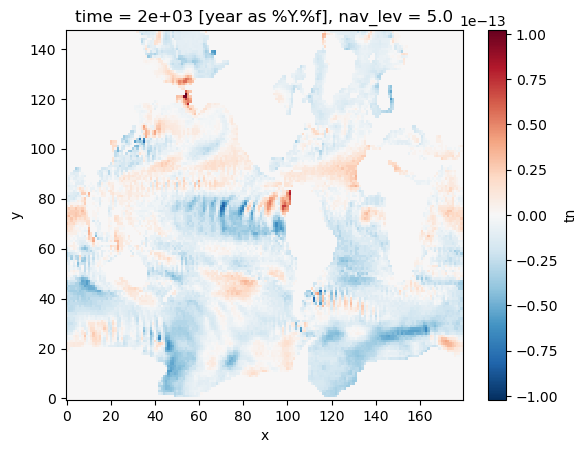

In [45]:
delta = xdata[var].isel(time=-1,nav_lev=0)-total[var].isel(nav_lev=0)
delta.plot()

In [46]:
df = elements(expname)

In [47]:
rpa = xdata[var].isel(time=-1).weighted(df['S']).mean(dim=['y', 'x'])
fpa = total[var].weighted(df['S']).mean(dim=['y', 'x'])

Text(0, 0.5, 'T')

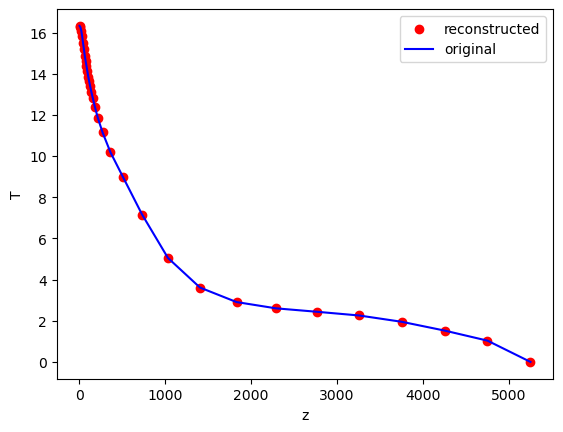

In [48]:
plt.scatter(fpa['nav_lev'].values,fpa.values, color='r', label='reconstructed')
plt.plot(rpa['nav_lev'].values,rpa.values, color='b', label='original')
plt.legend(loc="upper right")
plt.xlabel('z')
plt.ylabel('T')

Text(0, 0.5, 'T diff')

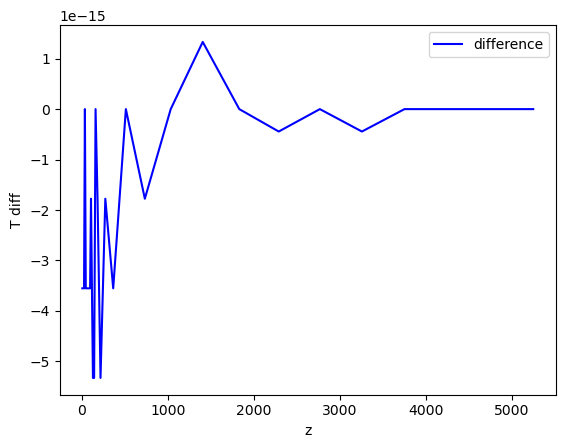

In [49]:
dpa = rpa-fpa 
plt.plot(rpa['nav_lev'].values, dpa.values, color='b', label='difference')
plt.legend(loc="upper right")
plt.xlabel('z')
plt.ylabel('T diff')